In [53]:
#Reading: https://blog.paperspace.com/detecting-and-localizing-pneumonia-from-chest-x-ray-scans-with-pytorch/
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
#!pip install torch==1.0.1 torchvision==0.2.2

     |████████████████████████████████| 560.1MB 29kB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 61kB 10.9MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0


In [0]:
###import packages for project

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd

In [0]:
## data augmentation with torchvision.transforms

transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
]),
'valid_transforms' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])}

In [0]:
trans = ['train_transforms','valid_transforms','test_transforms']

In [0]:
path = "/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/chest_xray/"
categories = ['train','val','test']
dset = {x : torchvision.datasets.ImageFolder(path+x, transform=transformers[y]) for x,y in zip(categories, trans)}

In [0]:
dataset_sizes = {x : len(dset[x]) for x in ["train","test","val"]}

In [59]:
for x in ["train","test","val"]:
  print('{}: {}'.format(x,dataset_sizes[x]))

train: 2624
test: 228
val: 16


In [0]:
num_threads = 0
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=16, shuffle=True, num_workers=num_threads)
               for x in categories} 

In [0]:
##Build model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,2),
            nn.LogSoftmax(dim=1)
        )
        for params in self.model.parameters():
            params.requires_grad = False
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataloaders, num_epochs):
        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(self.model.fc.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc =0.0
        if train_on_gpu:
            self.model = self.model.cuda()
        for epoch in range(1, num_epochs+1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)
            
            for phase in ['train','test']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0.0
                
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 600))
        print("best val acc: {:.4f}".format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model

In [0]:
model = Model()

In [80]:
#state_dict = torch.load("/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/model.pth.tar")
state_dict = torch.load("/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/Best_weights/best_pnemonia_model.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [81]:
model_ft = model.fit(dataloaders,1)


epoch 1/1
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train loss:  0.0354  acc: 0.9867
test loss:  0.6541  acc: 0.8246
time completed: 1m 66s
best val acc: 0.8246


In [0]:
#torch.save(model.state_dict(), "/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/Best_weights/best_pnemonia_model.pth")

In [0]:
#state_dict = torch.load("/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/best_pnemonia_model.pth")
#model.load_state_dict(state_dict, strict=False)
#model_ft = model.model

In [0]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

In [0]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [0]:
def predict_img(path):
  image_path = path
  img = image_loader(image_path)
  acts = LayerActivations(model_ft)
  img = img.cuda()
  logps = model_ft(img)
  ps = torch.exp(logps) 
  out_features = acts.features[0]
  out_features = torch.squeeze(out_features, dim=0)
  out_features = np.transpose(out_features.cpu(),axes=(1,2,0))
  W = model_ft.fc[0].weight
  top_probs, top_classes = torch.topk(ps, k=2)
  pred = np.argmax(ps.detach().cpu())
  w = W[pred,:]
  cam = np.dot(out_features.cpu(), w.detach().cpu())
  class_activation = nd.zoom(cam, zoom=(32,32),order=1)
  img = img.cpu()
  img = torch.squeeze(img,0)
  img = np.transpose(img,(1,2,0))
  mean = np.array([0.5,0.5,0.5])
  std =  np.array([0.5,0.5,0.5])
  img = img.numpy()
  img = (img + mean) * std
  img = np.clip(img, a_max=1, a_min=0)
  return img, class_activation, pred

In [0]:
test_dir='/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/Data_sample/'
from skimage.io import imread
from PIL import Image
import glob
image_list = []
for filename in glob.glob(test_dir+'/*.jpeg'): 
    #im=Image.open(filename)
    image_list.append(filename)

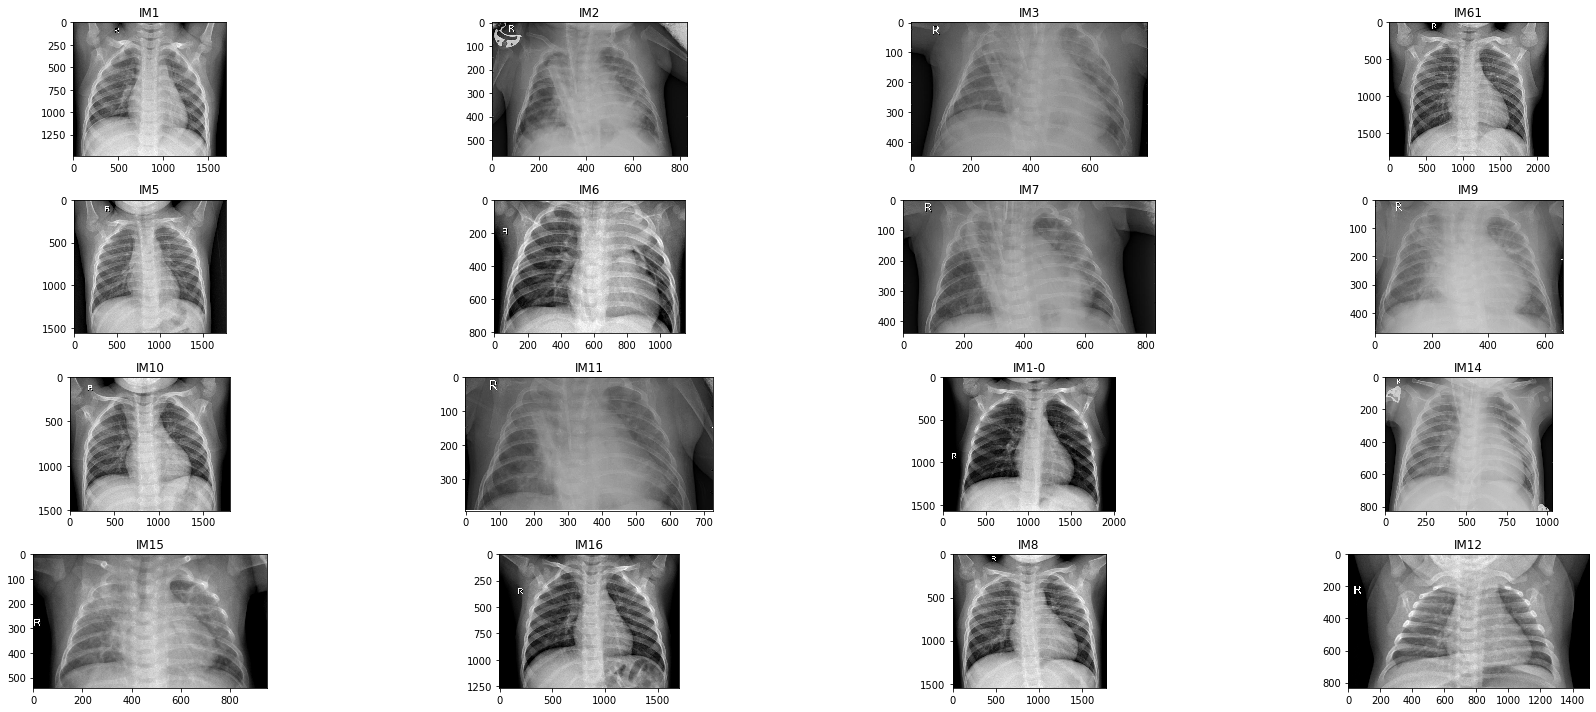

In [86]:
f, ax = plt.subplots(4,4, figsize=(30,10))

def plot_input(image_list):
  for i in range(len(image_list)):
      img = imread(image_list[i])
      name = image_list[i].split("/")
      name = name[len(name)-1].split(".")[0]
      ax[i//4, i%4].imshow(img, cmap='gray')
      ax[i//4, i%4].set_title(name)
      plt.tight_layout()
  plt.show()
plot_input(image_list)

In [87]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.transforms import Bbox

output_dir = '/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/Predicted_output/'
def plot_output(image_list):
  f, ax = plt.subplots(4,4, figsize=(50, 20))
  for i in range(len(image_list)):
    img, class_activation, pred = predict_img(image_list[i])
    name = image_list[i].split("/")
    name = name[len(name)-1].split(".")[0]
    ax.ravel()[i].imshow(class_activation, cmap='jet',alpha=1)
    ax.ravel()[i].imshow(img, alpha=0.55)
    ax.ravel()[i].set_title(dset['test'].classes[pred])
    extent = ax.ravel()[i].get_window_extent().transformed(f.dpi_scale_trans.inverted())
    f.savefig(output_dir + name + '_predicted.png', bbox_inches=extent.expanded(1.1, 1.2))
    plt.tight_layout()

  plt.show()

plot_output(image_list)